In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
pd.set_option("display.max_colwidth", 200) 
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import warnings 
warnings.filterwarnings("ignore")

Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
working_dir_path = 'Reviews.csv'
df = pd.read_csv(working_dir_path,encoding = 'latin')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


Assessing Dataset

In [10]:
df.shape

(568454, 10)

In [11]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [12]:
yolo = df[df['Score'] >= 4]
yolo


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,"I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there wa..."
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,"This saltwater taffy had great flavors and was very soft and chewy. Each candy was individually wrapped well. None of the candies were stuck together, which did happen in the expensive version, ..."
...,...,...,...,...,...,...,...,...,...,...
568448,568449,B001EO7N10,A1F6BHEYB7R6R7,James Braley,0,0,5,1308096000,Very large ground spice jars.,"My only complaint is that there's so much of it, I don't use a huge amount of 5 spice, so I gave 1 jar to my sister. Good enough."
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if not better than resturants I have eaten at..My husband loved it..will find other recipes to use this in..
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 of those in one training session. I tried to train our dog with ""Ceaser dog treats"", it just made our puppy hyper. If you compare the ingredients, y..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rewarding your dog for being good while grooming. Lower in calories and loved by all the doggies. Sweet potatoes seem to be their favorite Wet Noses tr...


Positive    18046
Negative    15398
Neutral      7713
Name: Sentiment, dtype: int64

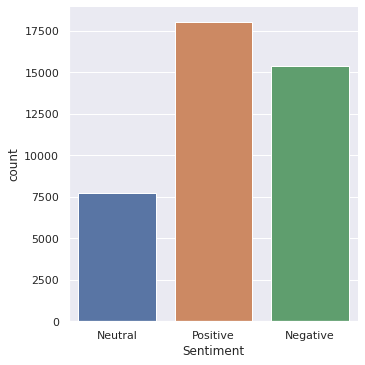

In [ ]:
sns.set(font_scale=1)
sns.catplot("Sentiment", data=df, kind="count", height=5)
df['Sentiment'].value_counts()

A) Removing @user, HTTP and URLs

In [ ]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt
# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

B) Removing Punctuations, Numbers, and Special Characters

In [ ]:
# remove special characters, numbers, punctuations
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')


C) Removing Short Words

In [ ]:
# remove short words
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

D) Tokenization

In [ ]:
# create new variable tokenized tweet 
tokenized_tweet = df['Tweet'].apply(lambda x: x.split())

E) Stemming

In [ ]:
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
# change df['Tweet'] to tokenized_tweet

df['Tweet']  = tokenized_tweet
df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Negative,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...


Extracting Features from cleaned dataset

In [ ]:
new_df = df[['Tweet','Sentiment']]

Removing Stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
new_df['Tweet'].apply(lambda x: [item for item in x if item not in stop])

0                                                                                                                                                                                                             []
1        [v, c,  , l, k,  , u, r,  , n, e, g, h, b, u, r,  , f, l,  , e, x, c, h, n, g,  , p, h, n, e,  , n, u, b, e, r,  , c, r, e,  , c, n, c,  , l,  , w, h,  , p, h, n, e,  , n, u, b, e, r,  , n, e, g, ...
2                                                            [c, r, n, v, r, u,  , u, r, l,  , w, l, w, r, h,  , g, v, e,  , e, l, e, r, l,  , b, l,  , e, c,  , h, p,  , h, u, r,  ,  , c, v,  , u, b, r, e, k]
3        [f,  , c, k,  , n,  , h, e,  , n, l,  , n, e,  , w, h, c, h,  , e, p,  , p, l, e,  , n,  , p, n, c,  , h, e, r, e,  , w, l, l,  , e, n, u, g, h,  , f,  , f, r,  , e, v, e, r, n,  , u,  , n,  , k, ...
4        [r, e,  , u, p, e, r, r, k, e,  , u, r, e,  , h, e,  , #, c, v,  , u, b, r, e, k,  , n,  , b, e, c, u,  , p, r, n,  , b, u,  , b, e, c, u,  , f,  , c, k,  

Spitting Our Dataset into Training And Testing Dataset ( For Multiclass Classification)

In [ ]:
train,valid = train_test_split(new_df,test_size = 0.2,random_state=0,stratify = new_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (32925, 2)
valid shape :  (8232, 2)


In [ ]:
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.Tweet.values)
X_valid = vectorizer.transform(valid.Tweet.values)

y_train = train.Sentiment.values
y_valid = valid.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_valid.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (32925, 27114)
X_valid.shape :  (8232, 27114)
y_train.shape :  (32925,)
y_valid.shape :  (8232,)


MULTICLASS Classification

1)Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_valid)
NB_accuracy = accuracy_score(y_valid,NB_prediction)
print("Training accuracy Score    : ", naiveByes_clf.score(X_train,y_train))
print("Testing accuracy Score : ", NB_accuracy )
print(classification_report(NB_prediction,y_valid))

Training accuracy Score    :  0.7800151860288534
Testing accuracy Score :  0.6845238095238095
              precision    recall  f1-score   support

    Negative       0.76      0.68      0.72      3428
     Neutral       0.26      0.70      0.38       571
    Positive       0.80      0.69      0.74      4233

    accuracy                           0.68      8232
   macro avg       0.61      0.69      0.61      8232
weighted avg       0.75      0.68      0.71      8232



2)Stochastic Gradient Descent-SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Testing accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.9167805618830676
Testing accuracy Score :  0.80988824101069
              precision    recall  f1-score   support

    Negative       0.81      0.83      0.82      3030
     Neutral       0.72      0.70      0.71      1577
    Positive       0.85      0.84      0.84      3625

    accuracy                           0.81      8232
   macro avg       0.79      0.79      0.79      8232
weighted avg       0.81      0.81      0.81      8232



3) Random Forest Classifier

In [ ]:
rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Testing accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_valid))

Training accuracy Score    :  0.9964464692482916
Testing accuracy Score :  0.7572886297376094
              precision    recall  f1-score   support

    Negative       0.75      0.78      0.77      2940
     Neutral       0.67      0.67      0.67      1553
    Positive       0.80      0.77      0.79      3739

    accuracy                           0.76      8232
   macro avg       0.74      0.74      0.74      8232
weighted avg       0.76      0.76      0.76      8232



4)Support Vector Machine

In [ ]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Testing accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_valid))

Training accuracy Score    :  0.9348823082763857
Testing accuracy Score :  0.7738095238095238
              precision    recall  f1-score   support

    Negative       0.78      0.79      0.79      3029
     Neutral       0.65      0.66      0.66      1519
    Positive       0.82      0.80      0.81      3684

    accuracy                           0.77      8232
   macro avg       0.75      0.75      0.75      8232
weighted avg       0.77      0.77      0.77      8232



5) Logistic Regression

In [ ]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Testing accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.9318451025056947
Testing accuracy Score :  0.7936103012633625
              precision    recall  f1-score   support

    Negative       0.81      0.81      0.81      3103
     Neutral       0.69      0.68      0.68      1567
    Positive       0.82      0.83      0.83      3562

    accuracy                           0.79      8232
   macro avg       0.77      0.77      0.77      8232
weighted avg       0.79      0.79      0.79      8232



Test Accuracies

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent'],
    'Test accuracy': [svc_accuracy, logreg_accuracy, 
              rf_accuracy, NB_accuracy, 
              sgd_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
4,Stochastic Gradient Decent,0.809888
1,Logistic Regression,0.793610
0,Support Vector Machines,0.773810
2,Random Forest,0.757289
3,Naive Bayes,0.684524


Understanding the emotions of people.

a) What are they feeling negetive about?

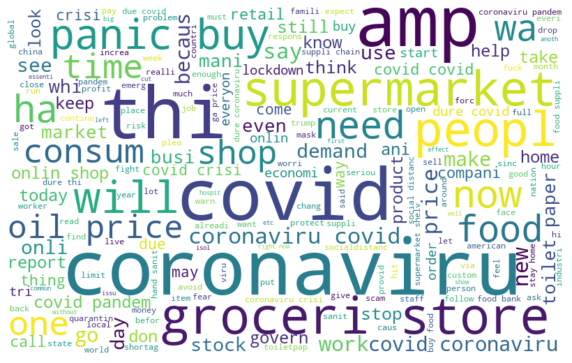

In [ ]:
# import numpy as npy
# from PIL import Image

from wordcloud import WordCloud
# create text from just normal tweets
normal_words = ' '.join([text for text in new_df['Tweet'][new_df['Sentiment'] == 'Negative']])

# mask_virus = npy.array(Image.open('/content/drive/MyDrive/NLP Group Project/Mask.png'))
wordcloud = WordCloud(width=800, height=500, background_color = 'white', random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


b) What are they feeling positive about?

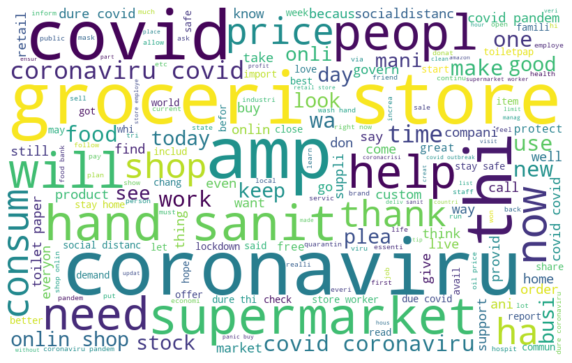

In [ ]:
# create text from just normal tweets
normal_words = ' '.join([text for text in new_df['Tweet'][new_df['Sentiment'] == 'Positive']])

# mask_virus = npy.array(Image.open('/content/drive/MyDrive/NLP Group Project/Mask.png'))
wordcloud = WordCloud(width=800, height=500, background_color = 'white', random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [ ]:
new_df

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Negative
...,...,...
41152,airlin pilot offer stock supermarket shelv #nz lockdown #covid,Neutral
41153,respons complaint not provid cite covid relat delay yet prompt reject polici befor consum tat over way,Negative
41154,you know get tough when ration toilet paper #coronaviru #toiletpap martinsvil help out,Positive
41155,wrong that the smell hand sanit start turn #coronaviru #covid #coronaviru,Neutral


Chart for negative words

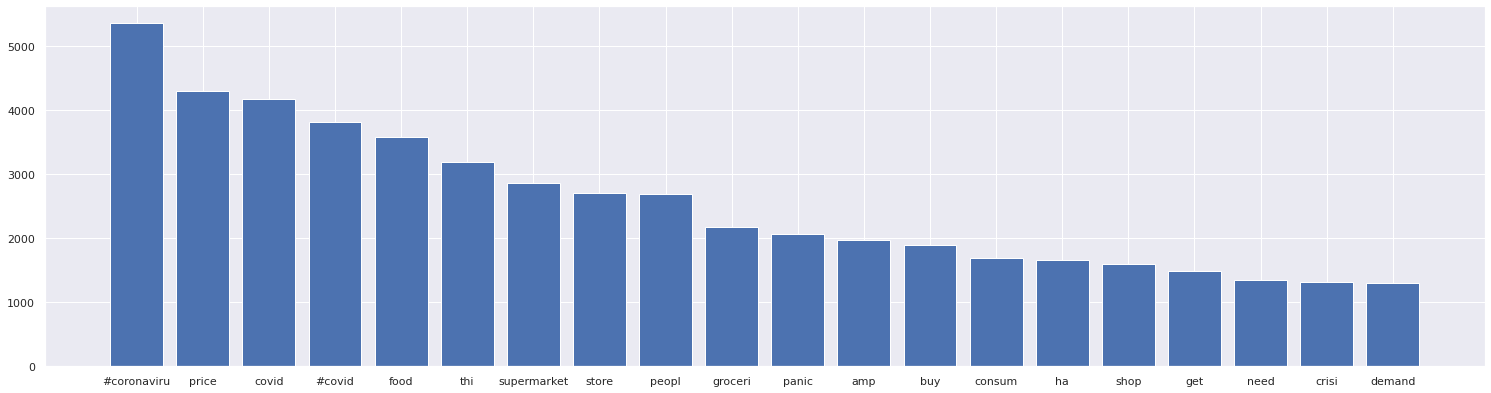

In [ ]:
neg_words = ' '.join([text for text in new_df['Tweet'][new_df['Sentiment'] == 'Negative']]).split()

neg_words_freq = {}
stop = list(stopwords.words('english'))


for word in neg_words:
  if word not in stop:
    if word not in neg_words_freq:
      neg_words_freq[word] = 1
    else:
      neg_words_freq[word] += 1


neg_words_freq = sorted(neg_words_freq.items(), key=lambda neg_words_freq: neg_words_freq[1], reverse=True)


neg_words_freq = neg_words_freq[:20]

plt.rcParams["figure.figsize"] = (20,5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
freqs = []
values = []

for idx,value in enumerate(neg_words_freq):
  freqs.append(value[0])
  values.append(value[1])

ax.bar(freqs,values)
plt.show()

Chart for positive words

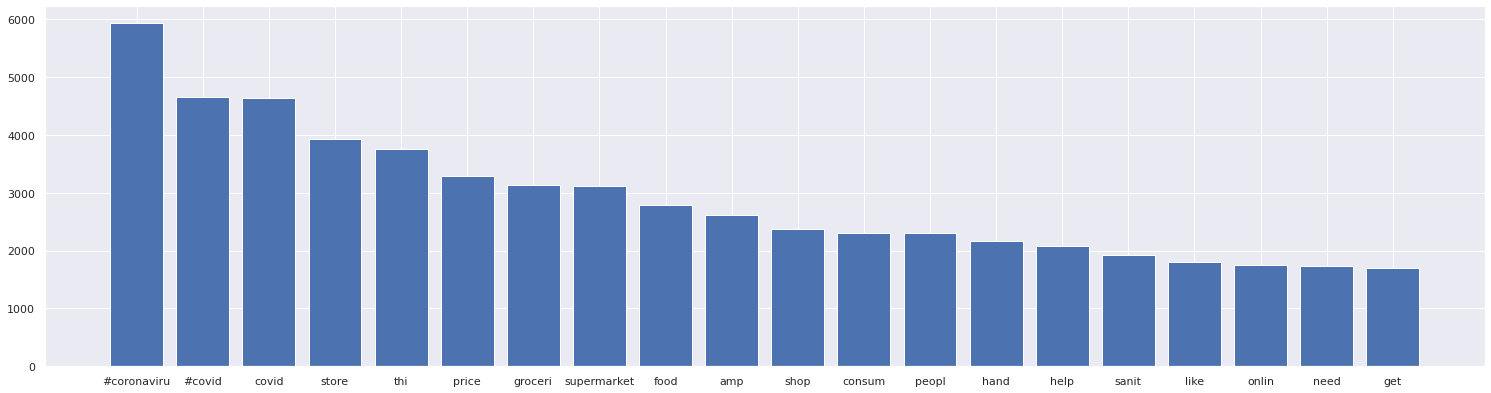

In [ ]:
pos_words = ' '.join([text for text in new_df['Tweet'][new_df['Sentiment'] == 'Positive']]).split()

pos_words_freq = {}
stop = list(stopwords.words('english'))

for word in pos_words:
  if word not in stop:
    if word not in pos_words_freq:
      pos_words_freq[word] = 1
    else:
      pos_words_freq[word] += 1


pos_words_freq = sorted(pos_words_freq.items(), key=lambda pos_words_freq: pos_words_freq[1], reverse=True)


pos_words_freq = pos_words_freq[:20]

plt.rcParams["figure.figsize"] = (20,5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
freqs = []
values = []

for idx,value in enumerate(pos_words_freq):
  freqs.append(value[0])
  values.append(value[1])

ax.bar(freqs,values)
plt.show()

In [ ]:
pos_words_freq

[('the', 20014),
 ('and', 11612),
 ('for', 6946),
 ('#coronaviru', 5925),
 ('you', 5436),
 ('are', 5181),
 ('#covid', 4657),
 ('covid', 4631),
 ('store', 3928),
 ('thi', 3759),
 ('price', 3295),
 ('groceri', 3136),
 ('that', 3123),
 ('with', 3121),
 ('supermarket', 3114),
 ('have', 3015),
 ('food', 2783),
 ('your', 2728),
 ('amp', 2617),
 ('all', 2516)]

In [ ]:
new_df['Tweet']

0                                                                                                                                                                                                               
1             advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order
2                                                                                                                         coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak
3        food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...
4        readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus 